# Introduction

In this notebook, we aim to predict the price of an Uber fare given minimal initial information. The data can be found on Kaggle at the link <https://www.kaggle.com/datasets/yasserh/uber-fares-dataset/>. 

The focus of this project is meticulous and in-depth feature engineering; after all, a model can only be as good as the data it was trained on. 

# Data Cleaning and Feature Extraction

We begin by loading in and inspecting the dataset.

In [165]:
import pandas as pd

#read in dataset
uber = pd.read_csv('uber_fare_prediction.csv')

#look at first few rows of dataset
uber.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


In [166]:
#look at datatype of each column
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  object 
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 12.2+ MB


We will first remove the `key` column, as this is a unique identifier and therefore does not contain useful information. Next, because there are very few non-null values, we will simply drop the rows which contain a null value.

In [167]:
#remove key column
uber = uber.iloc[:, 1:]

#drop rows which contain NA
uber.dropna(axis=0, inplace=True)

We want to extract useful features from the `pickup_datetime` column. To do so, we can first split the column into two features, one containing the date and the other containing the time of day.

In [168]:
#create new pickup_date and pickup_time features
uber[['pickup_date', 'pickup_time', 'garb']] = uber.pickup_datetime.str.split(pat=' ', expand=True)

#drop pickup_datetime column, no longer need it
uber.drop(labels=['pickup_datetime', 'garb'], axis=1, inplace=True)

We now import a new dataset which contains all of the holidays in the United States from 2004-2021, available on Kaggle at <https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021>. Then, we will perform a left merge with our current dataframe in order to determine which rides occurred on a holiday.

In [169]:
#read in holiday dataset
holiday = pd.read_csv('US Holiday Dates (2004-2021).csv')

#look at first few rows
holiday.head(10)

,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008
5,2009-07-04,4th of July,Saturday,7,4,2009
6,2010-07-04,4th of July,Sunday,7,4,2010
7,2011-07-04,4th of July,Monday,7,4,2011
8,2012-07-04,4th of July,Wednesday,7,4,2012
9,2013-07-04,4th of July,Thursday,7,4,2013


In [170]:
#perform left merge, then drop all extraneous columns
uber = pd.merge(left=uber, right=holiday, left_on='pickup_date', right_on='Date', how='left')
uber.drop(labels=['Date', 'WeekDay', 'Month', 'Day', 'Year'], axis=1, inplace=True)

From here, we can simply define a new binary feature which has a value of $1$ whenever the ride occurred on a holiday, and has a value of $0$ otherwise.

In [171]:
import numpy as np

#create binary feature indicating a holiday, then drop the column from the other dataset
uber['holiday'] = np.where(uber['Holiday'].isnull(), 0, 1)
uber = uber.drop(labels=['Holiday'], axis=1)

Our goal now is to extract useful features from the `pickup_date` and `pickup_time` columns. First, we separate out the date into year, month, and day of the month. Then, we can employ the `datetime` library to determine the day of the week for any given date. At the same time, we can discard all the information from `pickup_time` except for the hour, as the minutes and seconds have limited use.

In [172]:
import datetime

#separate pickup_date into three columns
uber[['year', 'month', 'day_of_month']] = uber.pickup_date.str.split(pat='-', expand=True).astype(int)
uber.drop(labels='pickup_date', axis=1, inplace=True)

#create column for day of week using datetime
weekday = lambda row: datetime.date(row['year'], row['month'], row['day_of_month']).isoweekday()
uber['day_of_week'] = uber.apply(weekday, axis=1)

#discard minutes and seconds from pickup_time
uber['time_of_day'] = uber.pickup_time.str.split(pat=':', expand=True).astype(int)[0]
uber.drop(labels='pickup_time', axis=1, inplace=True)

The time-based features should not be ordinal, because this implies an ordering which is not accurate. So, we implement a one-hot encoding for each of the time variables. Note that we make sure to set the parameter `drop_first=True` in order to avoid perfect collinearity.

In [173]:
#create one-hot encoding for time variables
uber = pd.get_dummies(uber, dtype=float, 
                        columns=['year', 'month', 'day_of_month', 'day_of_week', 'time_of_day'], 
                        drop_first=True).astype(float)

The final step in our data preparation is to extract Euclidean distance between the start and end locations from the latitude and longitude of the two locations via the Haversine formula:
$$
d = 2R\arcsin\left(\sqrt{\sin^2\left(\frac{\phi_2-\phi_1}{2} \right) + \cos\phi_1\cos\phi_2\sin^2\left(\frac{\lambda_2-\lambda_1}{2} \right)} \right),
$$
where $R$ is the radius of the Earth, $\phi$ is latitude, and $\lambda$ is longitude.

In [174]:
import math

#define function for haversine formula
def haversine(lon1, lat1, lon2, lat2):

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    return round(meters, 3)

#create feature for euclidean distance
eu_dist = lambda row: haversine(row.pickup_longitude, row.pickup_latitude, row.dropoff_longitude, row.dropoff_latitude)
uber['euclid_dist'] = uber.apply(eu_dist, axis=1)

# Fitting a Model to the Data

We will fit multiple regression models to the data. First, we perform an $80\%$-$20\%$ train-test split.

In [183]:
from sklearn.model_selection import train_test_split

#separate out features from target
X, y = uber.iloc[:, 1:].values, uber.iloc[:, 0].values

#do 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

First, we fit a linear regression to the training data.

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#instantiate linear regression object and fit to the training data
slr = LinearRegression()
slr.fit(X_train, y_train)

#evaluate on test data
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print('MSE train: {tr}, MSE test: {te}'.format(tr=mse_train.round(3), te=mse_test.round(3)))
print('MAE train: {tr}, MAE test: {te}'.format(tr=mae_train.round(3), te=mae_test.round(3)))
print('R^2 train: {tr}, R^2 test: {te}'.format(tr=r2_train.round(3), te=r2_test.round(3)))

MSE train: 94.534, MSE test: 94.534
MAE train: 5.933, MAE test: 5.97
R^2 train: 0.021, R^2 test: 0.019


As we can see from the metrics above, the simple linear regression model fails to capture the variance in the training set, and performs even worse on the test set. We will create a residuals plot as well to analyze why the model may be performing so poorly.

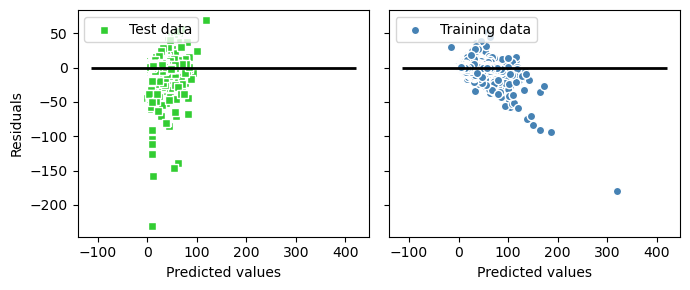

In [189]:
import matplotlib.pyplot as plt

#make residuals plot
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', marker='s', 
            edgecolor='white', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train, 
            c='steelblue', marker='o', 
            edgecolor='white', label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()
plt.show()

Ideally, the residuals would be exactly zero. In a real-world scenario, this will never happen. However, we do expect that, for a successful model, the residuals should be randomly distributed about the centerline. In other words, there should be no discernible pattern in the residuals plot. As we see above, the residuals follow clear patterns, so the linear regression model has failed to capture some of the explanatory information present in the training set.

It's likely that there are nonlinear relationships in the data set that the simple model cannot explain. Below, we fit a random forest regressor, which is much more capable of capturing nonlinearities.

In [190]:
from sklearn.ensemble import RandomForestRegressor

#fit model to data
rfr = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=42, n_jobs=-1)
rfr.fit(X_train, y_train)

#evaluate performance on the test set
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print('MSE train: {tr}, MSE test: {te}'.format(tr=mse_train.round(3), te=mse_test.round(3)))
print('MAE train: {tr}, MAE test: {te}'.format(tr=mae_train.round(3), te=mae_test.round(3)))
print('R^2 train: {tr}, R^2 test: {te}'.format(tr=r2_train.round(3), te=r2_test.round(3)))

MSE train: 2.987, MSE test: 2.987
MAE train: 0.733, MAE test: 1.997
R^2 train: 0.969, R^2 test: 0.78


We can see by the metrics above that the random forest regressor does a much better job of explaining the variance present in the data set. Although it clearly overfits somewhat to the training set, the random forest regressor still achieves an $R^2$ value of $0.78$ on the test set, which is a massive improvement over the linear regression, which only achieved an $R^2$ value of $0.019$ on the test set.